# Model With zero padding
X, y = pd.read_csv(file.csv)

X_train, y_train, X_test, y_test, X_val, y_val = train_test_split(X,y)

X_train[0] = 'AAGAU...C'

X_train = zero_padding_data_string(X_train, max_sequence)

==> X_train[0] = 'AAGAU...C000..00' & len(X_train[ i ]) = max_sequence    (for each i)

X_train = oneHot_encode(X_train):
  
  'A' --> [1, 0, 0, 0]

  'C' --> [0, 1, 0, 0]

  'G' --> [0, 0, 1, 0]

  'U' --> [0, 0, 0, 1]

  '0' --> [0, 0, 0, 0]

==> X_train[0] = [ [1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 0, 1], ..., [0, 1, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], ..., [0, 0, 0, 0]]

![Texte alternatif…](https://scontent.fymy1-2.fna.fbcdn.net/v/t1.15752-9/89344181_509619319961047_3942901636971626496_n.jpg?_nc_cat=105&_nc_sid=b96e70&_nc_ohc=30-4VWWDg_IAX8wnUju&_nc_ht=scontent.fymy1-2.fna&oh=8a28f9426b899ccabe78ed6788591a98&oe=5EB81833)




In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm import tnrange
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from librosa.util import pad_center
from time import time
import datetime
import pickle

In [0]:
data = pd.read_csv('data/LSTM_Models_data.csv')

In [0]:
#Split data
X = np.array(data.sequence)
y = np.array(data.id_family)
family_labels = np.unique(np.array(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [5]:
print(len(X_train))
print(len(X_test))

54039
18013


In [6]:
#Données de validations !
X_val1, X_val, y_val1, y_val = train_test_split(X_test, y_test, test_size=0.17)
len(X_val)

3063

In [7]:
# zero padding X_train pour booster l'entrainement
train_max_sequence = np.max([len(X_train[i]) for i in range(len(X_train))])
test_max_sequence = np.max([len(X_test[i]) for i in range(len(X_test))])

print(train_max_sequence)
print(test_max_sequence)

max_sequence = np.max([train_max_sequence, test_max_sequence])
max_sequence

4065
4021


4065

In [0]:
### Pading data strings ###
def zero_padding_data_string(data, max_seq):
  for i in tnrange(0, len(data)):
    data[i] = data[i].ljust(max_seq, '0')

In [9]:
### Pading training data strings X_train###
zero_padding_data_string(X_train, max_seq=max_sequence)
zero_padding_data_string(X_val, max_sequence)
zero_padding_data_string(X_test, max_sequence)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


In [0]:
 #Turning data into one hot coding
 
 def oneHot_encode(data):
  if isinstance(data,str) : # input is a string
    input_list = np.array(list(data))
    output = []
    for i in range(len(input_list)):
      if input_list[i] == 'A':
        output.append(np.array([1, 0, 0, 0]))
      elif input_list[i] == 'C':
        output.append(np.array([0, 1, 0, 0]))
      elif input_list[i] == 'G':
        output.append(np.array([0, 0, 1, 0]))
      elif input_list[i] == 'T':
        output.append(np.array([0, 0, 0, 1]))
      else :    #Padding !!
        output.append(np.array([0, 0, 0, 0]))
    return output
  else: # input is an array of strings
    return np.array([ np.array(oneHot_encode(data[i])) for i in tnrange(int(data.shape[0]))])
 

In [11]:
X_train = oneHot_encode(X_train)
X_test = oneHot_encode(X_test)
X_val = oneHot_encode(X_val)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


In [12]:
print(len(np.unique(y_train)))
print(len(np.unique(y_val)))

3016
1180


In [0]:
# OneHot Encoding labels: Just for now !!!
def one_hot_encode_labels(labels):
  output = []
  for i in tnrange(len(labels)):
    output_i = np.zeros(len(family_labels), dtype=int)
    output_i[labels[i]] = 1
    output.append(output_i)
  return np.array(output)

In [14]:
y_train = one_hot_encode_labels(y_train)
y_test = one_hot_encode_labels(y_test)
y_val = one_hot_encode_labels(y_val)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import LSTM, Dense, Reshape, Flatten, Activation, Multiply, Lambda
import numpy as np
from numpy import array
from keras import backend as K

inputs = Input(shape=(max_sequence, 4), name='input_layer')
encoder_out = LSTM(32, return_sequences=True, name='LSTM_layer')(inputs)

alpha = Dense(1, name='Attention_layer')(encoder_out)
alpha = Reshape(target_shape=(1, max_sequence))(alpha)
alpha = Activation('softmax', name='Activation_layer')(alpha)
alpha = Reshape(target_shape=(max_sequence, 1))(alpha)

decoder_in = Multiply(name='Multiply_layer')([encoder_out, alpha])
decoder_in = Lambda(lambda x: K.sum(x, axis=1), name='Sum_layer')(decoder_in) #Weighted sum

decoder_out = Dense(3016, activation='softmax', name='output_layer')(decoder_in)

model = Model(inputs=inputs, outputs=decoder_out)

model.summary(90)

Using TensorFlow backend.


Model: "model_1"
__________________________________________________________________________________________
Layer (type)                 Output Shape        Param #    Connected to                  
input_layer (InputLayer)     (None, 4065, 4)     0                                        
__________________________________________________________________________________________
LSTM_layer (LSTM)            (None, 4065, 32)    4736       input_layer[0][0]             
__________________________________________________________________________________________
Attention_layer (Dense)      (None, 4065, 1)     33         LSTM_layer[0][0]              
__________________________________________________________________________________________
reshape_1 (Reshape)          (None, 1, 4065)     0          Attention_layer[0][0]         
__________________________________________________________________________________________
Activation_layer (Activation (None, 1, 4065)     0          reshape_1[0][

In [16]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(54039, 4065, 4)
(54039, 3016)
(3063, 4065, 4)
(3063, 3016)
(18013, 4065, 4)
(18013, 3016)


In [0]:
#Train epochs is a function in which we se the number of epochs we want to train the model on and a boolean parameter which says whether we have already trained the model so we can continue on what we have done before
history_file_name = 'drive/My Drive/Colab Workspace/RNA_classification/models/LSTM_attention_history'
model_file_name = "drive/My Drive/Colab Workspace/RNA_classification/models/LSTM_attention.h5"
def train_epochs(n_epochs=1, already_trained=True):
  
  for i in range(n_epochs):
    
    if already_trained:
      # !!!!!!! Load old model with its history if the model has been trained before !!!!!!! 
      previous_history = pickle.load(open(history_file_name, "rb"))
      model.load_weights(model_file_name)

    
    # model training 
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val) ,epochs=1, verbose=1)
    
    if already_trained:
      #concatenate history if its been trained before !!!!!!!!!!
      history.history['loss'] = np.append(previous_history['loss'], history.history['loss'])
      history.history['val_loss'] = np.append(previous_history['val_loss'], history.history['val_loss'])
      
    model.save_weights(model_file_name)
    with open(history_file_name, 'wb') as file_pi:
          pickle.dump(history.history, file_pi)
    print("epoch: ", i+1)
    already_trained = True
  return history


In [0]:
history = train_epochs(n_epochs=10,already_trained=True)

In [20]:
history.history

{'loss': array([6.9244988 , 6.85484659, 6.63298805, 5.98578313, 5.76898339,
        5.49251391, 5.21152323, 5.03548303, 4.88744611, 5.04229536,
        4.74079502, 4.62728353, 4.47443116, 4.91501772, 4.45699623,
        4.24644064, 4.30839859, 4.0508591 , 3.94922558, 3.8388844 ,
        3.83684858, 4.26532775, 4.02864448, 3.53614992, 3.48143423,
        3.50669469, 3.47526374, 3.27199679, 3.22906301, 3.15289653,
        3.11444739, 4.19486508, 3.22608059, 3.13253322, 3.02709261,
        2.99766452, 2.96416906, 2.95510729, 2.8454338 , 2.81497524,
        2.76972397, 2.84236659, 2.74287248, 2.70662557, 2.67790872,
        2.72476455, 2.65328501, 2.6537731 , 2.72146712, 3.44842581,
        3.13076566, 3.32963614, 4.22533026, 3.59277511, 2.85661491,
        2.73057538, 2.74911003, 2.57386304, 2.52772149, 2.49271324,
        2.44435871, 2.4028552 , 2.37147883, 2.34921311, 2.33608933,
        2.6349057 , 2.34543975]),
 'val_loss': array([6.80790943, 6.81609806, 6.30726531, 5.69123731, 6.7208

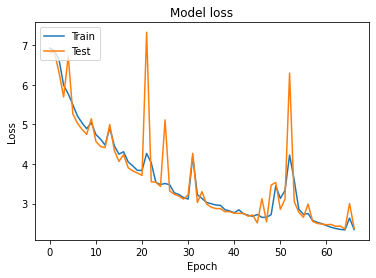

In [21]:
Plot training & validation loss values

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
#from tqdm import tnrange
def model_accuracy(data_test, labels_test):
  acc = 0
  for i in tnrange(len(data_test), desc='testing progress'):
    if np.argmax(model.predict(data_test[i].reshape(1, len(X_test[i]), 4))) == np.argmax(labels_test[i]):
      acc += 1
  return (acc/len(data_test))*100

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
test_acc = model.evaluate(x=X_test, y=y_test, verbose=1)
print("the model's accuracy is: ", test_acc, "%")

18013/18013 [==============================] - 138s 8ms/step
the model's accuracy is:  2.4024326072265723 %
